In [1]:
# add baseclasses to path 
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../baseclasses/')

from measurement_data import MeasurementData
from measurement_fitter import MeasurementFitter

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True

import numpy as np

from scipy.signal import argrelextrema


# Prepare data

In [3]:
#meas_data = MeasurementData("/home/pingu/Cloud/Studium/Studienarbeit/data/19CHButterfly_litho_1mmp/50µm/24 ml Ethanol/chip 1_4_66-1_4_69_33ml Zelle.csv")
meas_data = MeasurementData("/home/pingu/Cloud/Studium/Studienarbeit/data/19CHButterfly_litho_1mmp/50µm/24 ml NH3/chip 1_4_33_33ml Zelle.csv")
relative_data, _ = meas_data.get_smoothened_relative_data(0.) 
# func_data = meas_data.get_func_data()
# average_func_data = meas_data.get_func_data(func_vector_type="average")
smoothened_relative_data1, equally_spaced_t = meas_data.get_smoothened_relative_data(2.) 
smoothened_relative_data2, _ = meas_data.get_smoothened_relative_data(4.) 

Loading /home/pingu/Cloud/Studium/Studienarbeit/data/19CHButterfly_litho_1mmp/50µm/24 ml NH3/chip 1_4_33_33ml Zelle.csv


# View data loaded

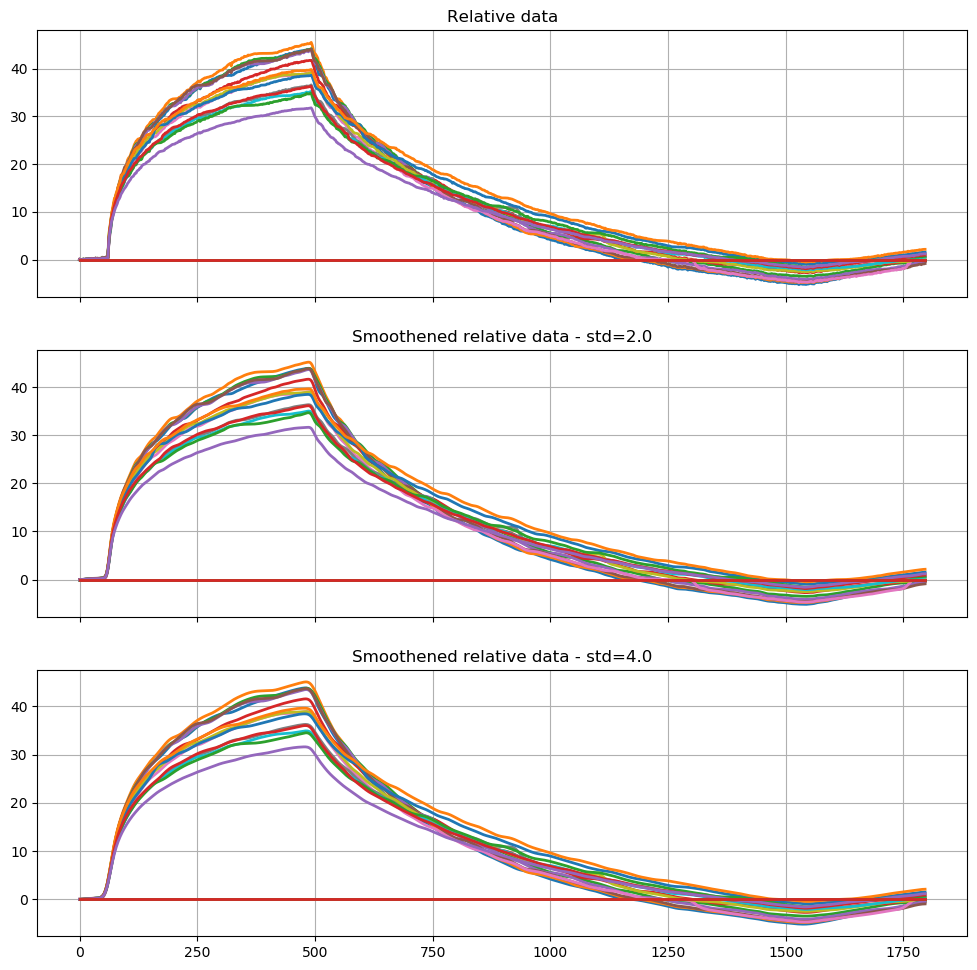

In [4]:
fig, axes = plt.subplots(3,1, figsize=(12,12), dpi=100, sharex=True)
axes[0].plot(equally_spaced_t, relative_data, linewidth=2)
axes[0].set_title('Relative data')

axes[1].plot(equally_spaced_t, smoothened_relative_data1, linewidth=2)
axes[1].set_title('Smoothened relative data - std=2.0')

axes[2].plot(equally_spaced_t, smoothened_relative_data2, linewidth=2)
axes[2].set_title('Smoothened relative data - std=4.0')
plt.show()

# Fit drift straights
Fit straights of length 6s to the smoothened data with std.

In [5]:
fitter = MeasurementFitter(meas_data, std=8.)
t_drift = 30
m, b, noise = fitter.fit_drift(t_drift)
m_diff, b_diff, t = fitter.get_slope_diffs(t_drift)

# Analyse exposition indicators

## Channel average
Use average value over all channels to determine broad exposition ranges. Failing channels are ignored.

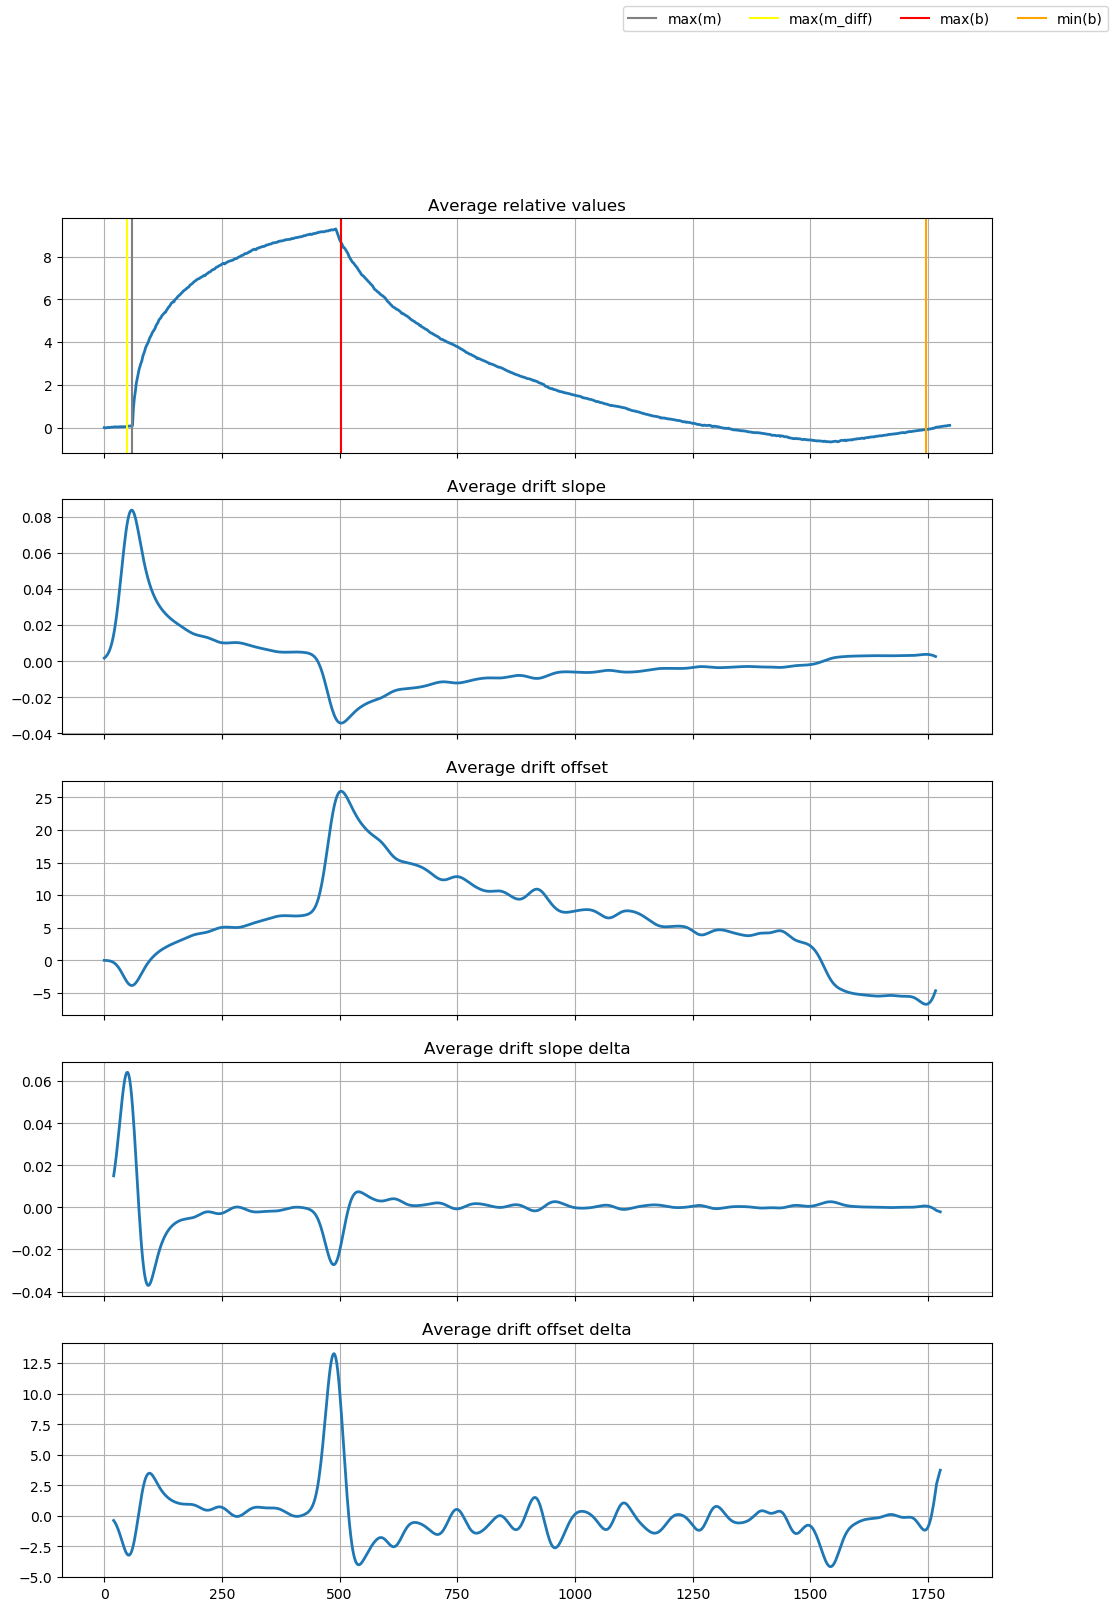

In [6]:
fFig, fAxes = plt.subplots(5,1, figsize=(12,18), dpi=100, sharex=True)
index = fitter.ts[:m.shape[0]]
fAxes[0].set_title("Average relative values")
fAxes[0].plot(fitter.ts, np.average(relative_data, axis=1), linewidth=2)

fAxes[1].set_title("Average drift slope")
fAxes[1].plot(index, np.average(m, axis=1), linewidth=2)

fAxes[2].set_title("Average drift offset")
fAxes[2].plot(index, np.average(b, axis=1), linewidth=2)

#fAxes[3].set_title("Average noise")
#fAxes[3].plot(index, np.average(noise, axis=1), linewidth=2)

fAxes[3].set_title("Average drift slope delta")
fAxes[3].plot(t, np.average(m_diff, axis=1), linewidth=2)

fAxes[4].set_title("Average drift offset delta")
fAxes[4].plot(t, np.average(b_diff, axis=1), linewidth=2)

# exposition start/ stop indicators
fAxes[0].axvline(x=fitter.ts[np.argmax(np.average(m, axis=1))], c='grey', label='max(m)')
fAxes[0].axvline(x=t[np.argmax(np.average(m_diff, axis=1))], c='yellow', label='max(m_diff)')
fAxes[0].axvline(x=fitter.ts[np.argmax(np.average(b, axis=1))], c='red', label='max(b)')
#fAxes[0].axvline(x=fitter.ts[np.argmin(np.average(m, axis=1))], c='white', label='min(m)')
# fAxes[0].axvline(x=t[np.argmin(np.average(m_diff, axis=1))], c='yellow', label='min(m_diff)') -> not suited
fAxes[0].axvline(x=fitter.ts[np.argmin(np.average(b, axis=1))], c='orange', label='min(b)')

# add legend
handles, labels = fAxes[0].get_legend_handles_labels()
fFig.legend(handles, labels, loc='upper right', ncol=8)

plt.show()

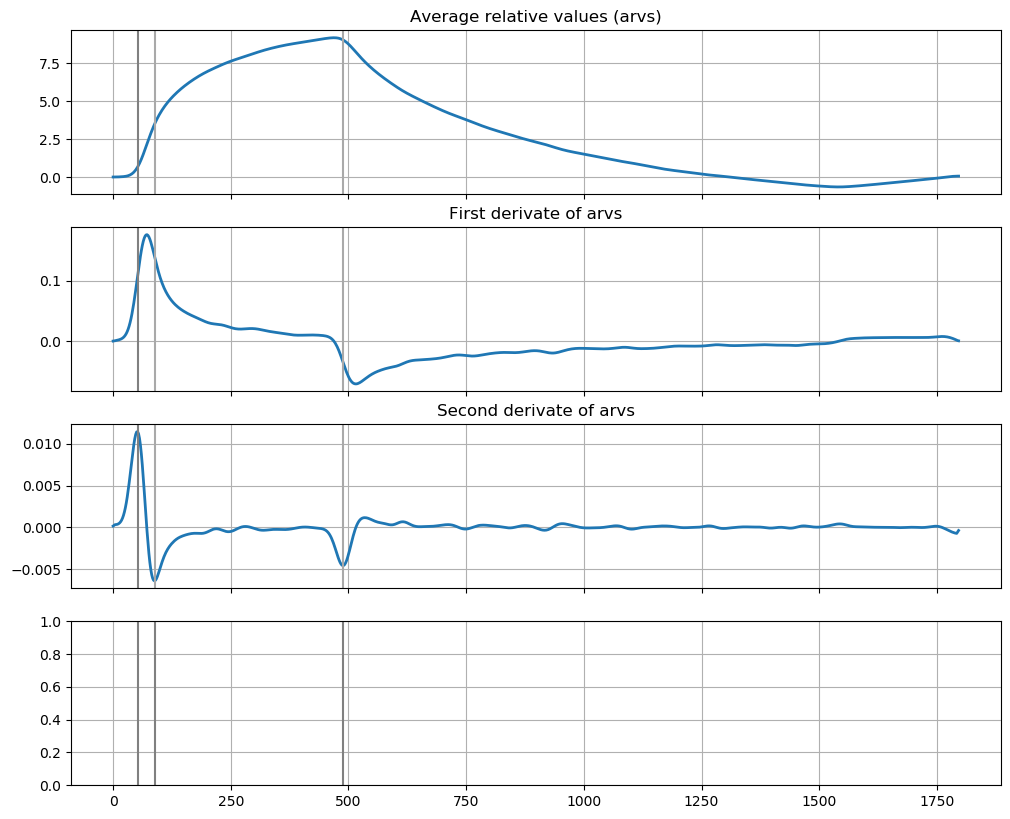

In [7]:
average_relative_data = np.average(fitter.channel_data, axis=1)

fFig, fAxes = plt.subplots(4,1, figsize=(12,10), dpi=100, sharex=True)
index = fitter.ts[:m.shape[0]]
fAxes[0].set_title("Average relative values (arvs)")
fAxes[0].plot(fitter.ts, average_relative_data, linewidth=2)

f_der = np.gradient(average_relative_data)
fAxes[1].set_title("First derivate of arvs")
fAxes[1].plot(fitter.ts, f_der, linewidth=2)

s_der = np.gradient(f_der)
fAxes[2].set_title("Second derivate of arvs")
fAxes[2].plot(fitter.ts, s_der, linewidth=2)

sd_max = argrelextrema(s_der, np.greater, axis=0, order=15)[0]
sd_min = argrelextrema(s_der, np.less, axis=0, order=15)[0]

# filter local extrema
sd_max = sd_max[s_der[sd_max] > 2.0 * np.average(s_der[sd_max])]
sd_min = sd_min[s_der[sd_min] < 2.0 * np.average(s_der[sd_min])]

for index in sd_max:
    fAxes[0].axvline(x=fitter.ts[index], c='grey', label='max(second derivate)')
    fAxes[1].axvline(x=fitter.ts[index], c='grey', label='max(second derivate)')
    fAxes[2].axvline(x=fitter.ts[index], c='grey', label='max(second derivate)')
    fAxes[3].axvline(x=fitter.ts[index], c='grey', label='max(second derivate)')
for index in sd_min:
    fAxes[0].axvline(x=fitter.ts[index], c='darkgrey', label='min(second derivate)')
    fAxes[1].axvline(x=fitter.ts[index], c='darkgrey', label='min(second derivate)')
    fAxes[2].axvline(x=fitter.ts[index], c='darkgrey', label='min(second derivate)')
    fAxes[3].axvline(x=fitter.ts[index], c='grey', label='min(second derivate)')

    
#b = np.multiply(f_der, -fitter.ts) + average_relative_data
#b_der = np.gradient(b)
#fAxes[3].set_title("60s offset")
#fAxes[3].plot(fitter.ts, b_der, linewidth=2)

#b_der_max = argrelextrema(b_der, np.greater, axis=0, order=15)[0]
#b_der_min = argrelextrema(b_der, np.less, axis=0, order=15)[0]

## filter local extrema
#b_der_max = b_der_max[b_der[b_der_max] > 2. * np.average(b_der[b_der_max])]
#b_der_min = b_der_min[b_der[b_der_min] < 2. * np.average(b_der[b_der_min])]

#for index in b_der_max:
#    fAxes[0].axvline(x=fitter.ts[index], c='yellow', label='max(second derivate)')
#    fAxes[1].axvline(x=fitter.ts[index], c='yellow', label='max(second derivate)')
#    fAxes[2].axvline(x=fitter.ts[index], c='yellow', label='max(second derivate)')
#    fAxes[3].axvline(x=fitter.ts[index], c='yellow', label='max(second derivate)')
#for index in b_der_min:
#    fAxes[0].axvline(x=fitter.ts[index], c='orange', label='min(second derivate)')
#    fAxes[1].axvline(x=fitter.ts[index], c='orange', label='min(second derivate)')
#    fAxes[2].axvline(x=fitter.ts[index], c='orange', label='min(second derivate)')
#    fAxes[3].axvline(x=fitter.ts[index], c='orange', label='min(second derivate)')
#fAxes[0].axvline(x=t[np.argmax(np.average(m_diff, axis=1))], c='yellow', label='max(m_diff)')
#fAxes[0].axvline(x=fitter.ts[np.argmax(np.average(b, axis=1))], c='red', label='max(b)')
#fAxes[0].axvline(x=fitter.ts[np.argmin(np.average(m, axis=1))], c='white', label='min(m)')
# fAxes[0].axvline(x=t[np.argmin(np.average(m_diff, axis=1))], c='yellow', label='min(m_diff)') -> not suited
#fAxes[0].axvline(x=fitter.ts[np.argmin(np.average(b, axis=1))], c='orange', label='min(b)')


plt.show()

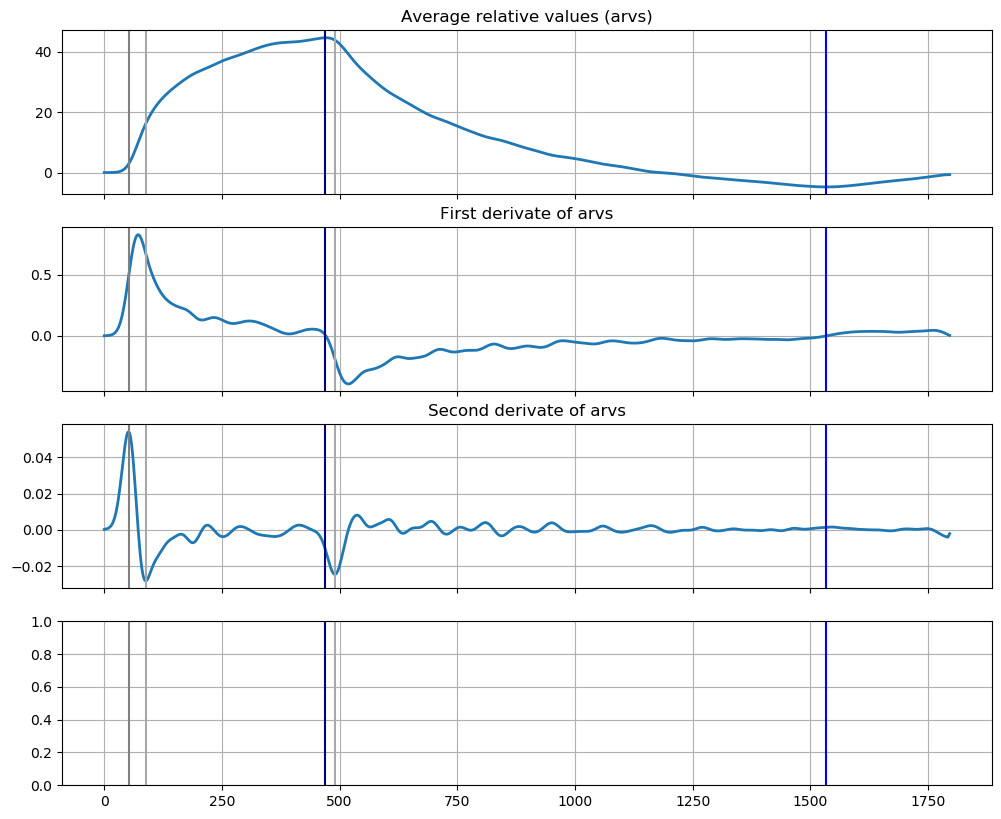

In [8]:
average_relative_data = fitter.channel_data[:,1]

fFig, fAxes = plt.subplots(4,1, figsize=(12,10), dpi=100, sharex=True)
index = fitter.ts[:m.shape[0]]
fAxes[0].set_title("Average relative values (arvs)")
fAxes[0].plot(fitter.ts, average_relative_data, linewidth=2)

f_der = np.gradient(average_relative_data)
fAxes[1].set_title("First derivate of arvs")
fAxes[1].plot(fitter.ts, f_der, linewidth=2)

s_der = np.gradient(f_der)
fAxes[2].set_title("Second derivate of arvs")
fAxes[2].plot(fitter.ts, s_der, linewidth=2)

sd_max = argrelextrema(s_der, np.greater, axis=0, order=15)[0]
sd_min = argrelextrema(s_der, np.less, axis=0, order=15)[0]

# filter local extrema
sd_max = sd_max[s_der[sd_max] > 2.0 * np.average(s_der[sd_max])]
sd_min = sd_min[s_der[sd_min] < 2.0 * np.average(s_der[sd_min])]

for index in sd_max:
    fAxes[0].axvline(x=fitter.ts[index], c='grey', label='max(second derivate)')
    fAxes[1].axvline(x=fitter.ts[index], c='grey', label='max(second derivate)')
    fAxes[2].axvline(x=fitter.ts[index], c='grey', label='max(second derivate)')
    fAxes[3].axvline(x=fitter.ts[index], c='grey', label='max(second derivate)')
for index in sd_min:
    fAxes[0].axvline(x=fitter.ts[index], c='darkgrey', label='min(second derivate)')
    fAxes[1].axvline(x=fitter.ts[index], c='darkgrey', label='min(second derivate)')
    fAxes[2].axvline(x=fitter.ts[index], c='darkgrey', label='min(second derivate)')
    fAxes[3].axvline(x=fitter.ts[index], c='darkgrey', label='min(second derivate)')
    
# relative min / max
rel_max = argrelextrema(average_relative_data, np.greater, axis=0, order=15)[0]
rel_min = argrelextrema(average_relative_data, np.less, axis=0, order=15)[0]

for index in rel_max:
    fAxes[0].axvline(x=fitter.ts[index], c='darkblue', label='max(relative data)')
    fAxes[1].axvline(x=fitter.ts[index], c='darkblue', label='max(relative data)')
    fAxes[2].axvline(x=fitter.ts[index], c='darkblue', label='max(relative data)')
    fAxes[3].axvline(x=fitter.ts[index], c='darkblue', label='max(relative data)')
for index in rel_min:
    fAxes[0].axvline(x=fitter.ts[index], c='blue', label='min(relative data)')
    fAxes[1].axvline(x=fitter.ts[index], c='blue', label='min(relative data)')
    fAxes[2].axvline(x=fitter.ts[index], c='blue', label='min(relative data)')
    fAxes[3].axvline(x=fitter.ts[index], c='blue', label='min(relative data)')
    
plt.show()

In [20]:



print(sd_max)
print(sd_min)

[28]
[ 37 245]


In [21]:
from scipy.signal import argrelextrema

m_diff_maxima = argrelextrema(np.average(m_diff, axis=1), np.greater, axis=0, order=30)
m_diff_minima = argrelextrema(np.average(m_diff, axis=1), np.less, axis=0, order=30)

print(m_diff_maxima)
print(m_diff_minima)

(array([ 16, 130, 193, 255, 298, 346, 381, 428, 466, 525, 575, 623, 660,
       762, 864]),)
(array([ 32, 149, 234, 313, 364, 449, 491, 540, 595, 637, 710, 827]),)


In [10]:
%whos

Variable                    Type               Data/Info
--------------------------------------------------------
MeasurementData             type               <class 'measurement_data.MeasurementData'>
MeasurementFitter           type               <class 'measurement_fitter.MeasurementFitter'>
axes                        ndarray            3: 3 elems, type `object`, 24 bytes
equally_spaced_t            ndarray            899: 899 elems, type `float64`, 7192 bytes
fig                         Figure             Figure(1200x1200)
meas_data                   MeasurementData    <measurement_data.Measure<...>object at 0x7ff74cc55550>
np                          module             <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
plt                         module             <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
relative_data               ndarray            899x64: 57536 elems, type `float64`, 460288 bytes (449.5 kb)
smoothened_relative_data1   ndarray            